In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU,Conv1D,MaxPooling1D
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model


In [2]:
pd.set_option('display.max_columns', 50)

adidas_final_df = pd.read_csv('../data_preprocessing/adidas_final_df.csv')
adidas_final_df

,id,brand,model,product_name,condition,last_sale,last_sale_size,lowest_ask,highest_bid,since_last_sale_dollar,since_last_sale_percent,colorway,retail_price,release_date,high_52_week,low_52_week,low_12_month_trade,high_12_month_trade,volatility,num_sales_12_month,price_premium_12_month,avg_sale_price_12_month,period
0,adidas-rs-replicant-ozweego-raf-simons-colonia...,adidas,rs,adidas rs replicant ozweego raf simons colonia...,New,21100.0,7.5,24300.0,16700.0,-15800.0,-43.0,Core Black/Colonial Blue/Core Black,57585.0,2018-03-15,36900.0,8500.0,15300.0,26900.0,27.7,21.0,-63.6,19300.0,948.0
1,adidas-eqt-running-guidance-solebox,adidas,eqt,adidas eqt running guidance solebox,New,18700.0,9,20600.0,16700.0,-3400.0,-16.0,NaN,14134.5,2014-12-06,23200.0,18700.0,16800.0,20600.0,10.0,4.0,31.1,20900.0,2143.0
2,adidas-ultra-boost-reigning-champ-grey,adidas,ultra,adidas ultra boost 3.0 reigning champ grey,New,21100.0,12,20600.0,19400.0,600.0,3.0,NaN,20940.0,2017-04-07,35100.0,17900.0,16500.0,25800.0,21.8,51.0,NaN,22900.0,1290.0
3,adidas-adistar-comp-a-d,adidas,adistar,adidas adistar comp a/d,New,3300.0,10.5,4800.0,3100.0,-300.0,-9.0,NaN,16752.0,2017-09-21,7000.0,3300.0,1600.0,5000.0,50.4,3.0,-80.6,4700.0,1123.0
4,adidas-ultra-boost-20-core-black-night-metallic,adidas,ultra,adidas ultra boost 20 core black night metallic,New,10700.0,7.5,9300.0,10000.0,400.0,3.0,Core Black/Night Metallic/Cloud White,18846.0,2019-12-06,19000.0,5300.0,10200.0,11200.0,5.2,749.0,-43.9,11000.0,317.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847,adidas-sobakov-clear-orange-core-black,adidas,sobakov,adidas sobakov clear orange core black,New,5300.0,8,5700.0,6300.0,1000.0,23.0,Clear Orange/Core Black/Crystal White,12564.0,2018-10-04,8500.0,2700.0,3600.0,7000.0,32.6,66.0,-58.3,5400.0,745.0
3848,adidas-deerupt-cloud-white-core-black,adidas,deerupt,adidas deerupt cloud white core black,New,10600.0,10,10600.0,10500.0,200.0,1.0,Cloud White/Cloud White/Core Black,10470.0,2018-07-05,16200.0,4800.0,8900.0,12300.0,15.7,55.0,NaN,8600.0,836.0
3849,adidas-ultra-boost-light-bone-2-0,adidas,ultra,adidas ultra boost 2.0 clear onix,New,23200.0,11,19500.0,16800.0,4300.0,22.0,NaN,18846.0,2016-10-19,29600.0,13200.0,18700.0,27800.0,19.5,12.0,22.2,19800.0,1460.0
3850,adidas-predator-precision-turf-blue-white-red,adidas,predator,adidas predator precision turf blue white red,New,49500.0,11,NaN,21000.0,23100.0,87.0,NaN,18846.0,2017-09-01,49500.0,26500.0,39700.0,59400.0,19.9,3.0,160.8,35900.0,1143.0


In [3]:
model_name = adidas_final_df['product_name']
model_name

0       adidas rs replicant ozweego raf simons colonia...
1                     adidas eqt running guidance solebox
2              adidas ultra boost 3.0 reigning champ grey
3                                 adidas adistar comp a/d
4         adidas ultra boost 20 core black night metallic
                              ...                        
3847               adidas sobakov clear orange core black
3848                adidas deerupt cloud white core black
3849                    adidas ultra boost 2.0 clear onix
3850        adidas predator precision turf blue white red
3851                    adidas eqt guidance 93 sneakers76
Name: product_name, Length: 3852, dtype: object

In [4]:
max_features = 20000

#num_words: 利用する単語の最大数
#char_level: Trueなら，全文字はトークンとして扱われる
tokenizer = Tokenizer(num_words=max_features,char_level=True)
tokenizer.fit_on_texts(list(model_name))
list_tokenized = tokenizer.texts_to_sequences(model_name)
print(len(list_tokenized[1]))
list_tokenized[1]

35


[2,
 3,
 5,
 3,
 2,
 6,
 1,
 4,
 36,
 9,
 1,
 7,
 13,
 11,
 11,
 5,
 11,
 18,
 1,
 18,
 13,
 5,
 3,
 2,
 11,
 12,
 4,
 1,
 6,
 8,
 10,
 4,
 14,
 8,
 28]

In [5]:
pickle.dump(tokenizer, open(os.path.join('../objects', 'tokenizer.pkl'), 'wb'), protocol=4)

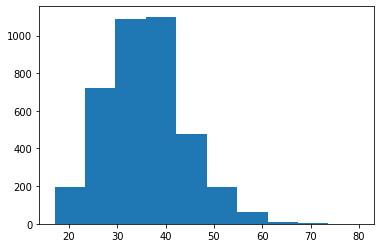

In [6]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized]
plt.hist(totalNumWords)
plt.show()

In [7]:
maxlen = 80

#maxlen: シーケンスの最大長
X = pad_sequences(list_tokenized, maxlen=maxlen)
X.shape

(3852, 80)

In [8]:
#Functional API
#入力
inp = Input(shape=(maxlen, ))
embed_size = 480
x = Embedding(len(tokenizer.word_index)+1, embed_size)(inp)
#padding="same"は元の入力と同じ長さを出力がもつように入力にパディング
x = Conv1D(filters=360, kernel_size=4, padding='same', activation='relu')(x)
x=MaxPooling1D(pool_size=4)(x)
x = Bidirectional(GRU(300, return_sequences=True,name='lstm_layer',dropout=0.2,recurrent_dropout=0.2))(x)
x = GlobalMaxPool1D()(x)
x = Dense(256, activation="relu", name='hidden')(x)
x = Dropout(0.2)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                 metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 480)           24960     
_________________________________________________________________
conv1d (Conv1D)              (None, 80, 360)           691560    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 360)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 600)           1191600   
_________________________________________________________________
global_max_pooling1d (Global (None, 600)               0         
_________________________________________________________________
hidden (Dense)               (None, 256)               153856

In [9]:
layer_name = 'hidden'
hidden_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
hidden = hidden_model.predict(X)
print(hidden.shape)

(3852, 256)


In [10]:
hidden_model.save(os.path.join('../objects', 'text_cnn.h5'))

In [11]:
text_df = pd.DataFrame(hidden)
text_df.to_csv('../data/text_features/text_df_256.csv', index=False)